# gpt2_basic_training
## 2025DEC08


## 1. package loading

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
import tiktoken
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
import json
from copy import deepcopy


## 2. setup paths for llm package load

In [2]:

PROJECT_ROOT = Path().resolve().parents[0]          # -> .../project_root
SRC_DIR = PROJECT_ROOT / "src"           # -> .../project_root/src
print(SRC_DIR)

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from llm_from_scratch.configs import gpt2small_config
from llm_from_scratch.training import training_utils
from llm_from_scratch.models import gpt2
from llm_from_scratch.dataloader import dataloader

/home/markb/llm-from-scratch/src


## 3. setup run_training()

In [3]:
def run_training(cfg):
    """Run a single training experiment given a config dict."""
    cfg = deepcopy(cfg)  # avoid in-place mutation

    model_cfg = cfg['model_config']
    device = cfg['device_name']
    torch.manual_seed(cfg['seed'])
    print(cfg)
    # modify cfg)
    # setup model
    model = gpt2.setup_model(model_cfg)
    totparams = sum(p.numel() for p in model.parameters())
    print("Total number of parameters:", totparams)

    # DEBUG: check model
    print("weight_tying flag:", model_cfg["weight_tying"])
    print("same object?:", model.out_head.weight is model.tok_emb.weight)
    print("out_head.weight shape:", model.out_head.weight.shape)
    print("tok_emb.weight shape:", model.tok_emb.weight.shape)


    # tokenizer
    tokenizer = tiktoken.get_encoding(cfg['tokenizer'])

    # dataloaders
    train_loader, val_loader, test_loader = dataloader.generate_data_loaders(cfg)
    print("Show train_loader first entry (converted to text):")
    dataloader.loader_text_examine(train_loader, 0, tokenizer)
    print("Show val_loader first entry (converted to text):")
    dataloader.loader_text_examine(val_loader, 0, tokenizer)
    if test_loader is not None:
        print("Show test_loader first entry (converted to text):")
        dataloader.loader_text_examine(test_loader, 0, tokenizer)
    
    # DEBUG: check
    # get one batch
    # input_batch, target_batch = next(iter(train_loader))
    # input_batch = input_batch.to(device)
    # target_batch = target_batch.to(device)

    # with torch.no_grad():
    #     logits = model(input_batch)

    # print("tok_emb weight: mean, std:",
    #     model.tok_emb.weight.mean().item(),
    #     model.tok_emb.weight.std().item())
    # print("out_head weight: mean, std:",
    #     model.out_head.weight.mean().item(),
    #     model.out_head.weight.std().item())

    # print("embeds std:", model.tok_emb(input_batch).std().item())
    # print("logits: mean, std, min, max:",
    #     logits.mean().item(),
    #     logits.std().item(),
    #     logits.min().item(),
    #     logits.max().item())


    # training loop
    model.train()
    num_epochs = cfg['num_epochs']
    optimizer = training_utils.setup_optimizer(model, cfg)
    train_losses, val_losses, tokens_seen, global_step = training_utils.train_model_simple(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=cfg['device_name'],
        num_epochs=cfg['num_epochs'],
        eval_freq=5,
        eval_iter=5,
        start_context="Every effort moves you",
        tokenizer=tokenizer
    )

    # plot and save plot
    epochs_tensor = torch.linspace(0, cfg['num_epochs'], len(train_losses))
    training_utils.plot_losses(cfg, epochs_tensor, tokens_seen, train_losses, val_losses)

    # save cfg and checkpoint
    training_utils.save_cfg_json(
        cfg=cfg, 
        epoch=num_epochs, 
        global_step=global_step) 
    # DEBUG: temp disable 
    # training_utils.save_checkpoint(
    #     model=model,
    #     optimizer=optimizer,
    #     cfg=cfg,
    #     epoch=cfg['num_epochs'],
    #     global_step=global_step,
    # )
    training_utils.save_results(cfg,
        train_losses, val_losses, tokens_seen, global_step)
    

    # return some results
    return {
        "final_train_loss": float(train_losses[-1]),
        "final_val_loss": float(val_losses[-1]),
        "tokens_seen": int(tokens_seen[-1]),
        "global_step": int(global_step),
    }



## 4. EXPERIMENT 1: basic params

### configs

In [23]:
cfg = gpt2small_config.RUN_CONFIG
cfg
cfg2 = deepcopy(cfg)
cfg2['run_name'] = "gpt2_another_basic_exp_1"
cfg2['num_epochs']=6 # just to check things

### run model

{'run_name': 'gpt2_another_basic_exp_1', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/the-verdict.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 256, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 162419712
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 768])
tok_emb.weight shape: torch.Size([50257, 768])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/the-verdict.txt
Characters: 20479
Tokens: 5145


Show train_loader first entry (converted to text):
I HAD alway

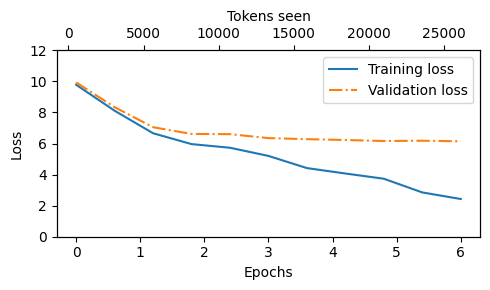

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_another_basic_exp_1/epoch006_step0000053_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_another_basic_exp_1/epoch006_step0000053_results.json


{'final_train_loss': 2.427326130867004,
 'final_val_loss': 6.14096212387085,
 'tokens_seen': 26112,
 'global_step': 53}

In [5]:
run_training(cfg2)

## Experiment 1a: make sure that model really resets

In [6]:
#cfg2['run_name']="gpt2_basic_exp_1a"
#run_training(cfg2)

## Experiment 1b: try alternate text
There are two rationales for this, one for this current work and one looking forward.
1. For this current work, it is interesting to see if different corpora perform significantly differently. Both are open source short stories (or part of a short story, truncated to be similar length to the first, for the second). This is just a basic check to see if reasonably similar sources vary much. Note also the concern that the test set is simply the last part of each story; this could easily have different characteristics than the rest of the text. Visual inspection doesn't reveal anything crazy (like if the last part were an author's note with different words and style than earlier) - but this could obviously be quantified by looking at word frequency or ngram frequency, etc. Simply comparing loss curves (both training and validation) for these two stories allows a quick and dirty examination of the effect of source material, when the source material is similar. 

2. Longer run: rationale for this is that there is a concern that "the-verdict" text may have been part of the training set of GPT2. I found an "open source" text that is from ~2024/2025, so should not have been part of the ~2019 training of GPT2. This is not an issue here with training from scratch, but for continued pre-training and evaluation, it is. So the test here is to see if this alterate text performs similarly, so I can use it with continued pre-training experiments in the GPT2-small framework.  

3. I expect minor some minor differences; these texts are sylistically quite different in many ways, which can affect training.  


{'run_name': 'gpt2_basic_exp_1b', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 256, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 162419712
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 768])
tok_emb.weight shape: torch.Size([50257, 768])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (co

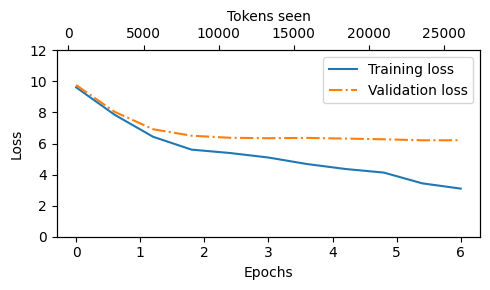

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_1b/epoch006_step0000053_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_1b/epoch006_step0000053_results.json


{'final_train_loss': 3.095401430130005,
 'final_val_loss': 6.206756591796875,
 'tokens_seen': 26112,
 'global_step': 53}

In [ ]:
cfg2['run_name']="gpt2_basic_exp_1b"
cfg2['description']="gpt2 with the adjusted watch story"
# "training_file": "/home/markb/llm-from-scratch/data/the-verdict.txt"
cfg2['training_file'] = "/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt"
run_training(cfg2)

### RESULTS  
1. Curves are quite similar with the two texts.  
2. With identical number of tokens seen, have somewhat larger training loss with the watch vs the verdict and slightly higher validation loss.  
3. Implications:  
    a. these texts do not appear to be some crazy texts that would mess with interpretation in these simple basic frameworks.  
    b. these texts can both be used later on for looking at the pre-trained models. The first text may have been part of the training set for the GPT2-small, but the second text is well after the training cutoff, so almost certainly was not.

## Experiment 2: change stride to do more training

In [8]:
cfg2['run_name']="gpt2_basic_exp_2"
cfg2['stride']=128
cfg2

{'run_name': 'gpt2_basic_exp_2',
 'description': 'gpt2-small on the verdict',
 'device_name': 'cpu',
 'model_name': 'gpt2-small',
 'model_config': {'vocab_size': 50257,
  'context_length': 256,
  'emb_dim': 768,
  'n_heads': 12,
  'n_layers': 12,
  'drop_rate': 0.1,
  'qkv_bias': False,
  'weight_tying': False},
 'tokenizer': 'gpt2',
 'pretrained': False,
 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt',
 'val_file': '',
 'test_file': '',
 'val_ratio': 0.1,
 'test_ratio': 0.0,
 'stride': 128,
 'batch_size': 2,
 'lr': 0.0004,
 'weight_decay': 0.1,
 'num_epochs': 6,
 'seed': 123,
 'output_dir': '/home/markb/llm-from-scratch/output'}

### run model

{'run_name': 'gpt2_basic_exp_2', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 162419712
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 768])
tok_emb.weight shape: torch.Size([50257, 768])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (con

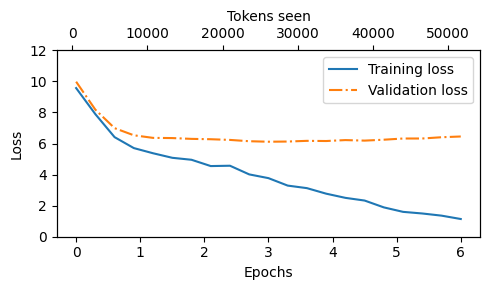

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_2/epoch006_step0000101_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_2/epoch006_step0000101_results.json


{'final_train_loss': 1.139970076084137,
 'final_val_loss': 6.451103448867798,
 'tokens_seen': 51712,
 'global_step': 101}

In [9]:
run_training(cfg2)

## Experiment 3: make a much smaller model 2 layers, 2 heads, and emb_dim of 256

In [10]:
cfg2['run_name']="gpt2_basic_exp_3"
cfg2['model_config']["emb_dim"]= 256         # Embedding dimension
cfg2['model_config']["n_heads"]= 2          # Number of attention heads
cfg2['model_config']["n_layers"]= 2          # Number of layers
cfg2

{'run_name': 'gpt2_basic_exp_3',
 'description': 'gpt2-small on the verdict',
 'device_name': 'cpu',
 'model_name': 'gpt2-small',
 'model_config': {'vocab_size': 50257,
  'context_length': 256,
  'emb_dim': 256,
  'n_heads': 2,
  'n_layers': 2,
  'drop_rate': 0.1,
  'qkv_bias': False,
  'weight_tying': False},
 'tokenizer': 'gpt2',
 'pretrained': False,
 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt',
 'val_file': '',
 'test_file': '',
 'val_ratio': 0.1,
 'test_ratio': 0.0,
 'stride': 128,
 'batch_size': 2,
 'lr': 0.0004,
 'weight_decay': 0.1,
 'num_epochs': 6,
 'seed': 123,
 'output_dir': '/home/markb/llm-from-scratch/output'}

{'run_name': 'gpt2_basic_exp_3', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 256, 'n_heads': 2, 'n_layers': 2, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 27375616
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 256])
tok_emb.weight shape: torch.Size([50257, 256])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (conver

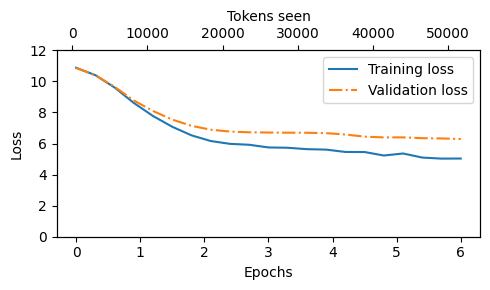

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_3/epoch006_step0000101_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_3/epoch006_step0000101_results.json


{'final_train_loss': 5.03342924118042,
 'final_val_loss': 6.291564464569092,
 'tokens_seen': 51712,
 'global_step': 101}

In [11]:
run_training(cfg2)

## Experiment 4: do more epochs

In [12]:
cfg2['run_name']="gpt2_basic_exp_4"
cfg2['num_epochs']=8

{'run_name': 'gpt2_basic_exp_4', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 256, 'n_heads': 2, 'n_layers': 2, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 8, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 27375616
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 256])
tok_emb.weight shape: torch.Size([50257, 256])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (conver

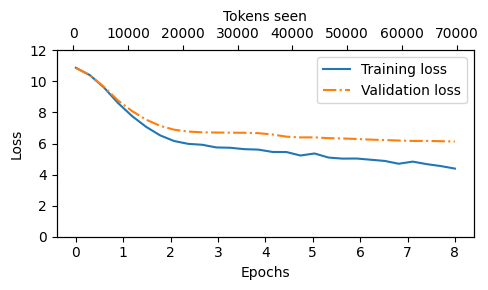

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_4/epoch008_step0000135_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_4/epoch008_step0000135_results.json


{'final_train_loss': 4.3853936195373535,
 'final_val_loss': 6.128213167190552,
 'tokens_seen': 69632,
 'global_step': 135}

In [13]:
run_training(cfg2)

## Experiment 5: mini-model, 2 layers, 4 heads per layer, 6 epochs

In [14]:
cfg2['run_name']="gpt2_basic_exp_5"
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=2
cfg2['model_config']['n_heads']=4
cfg2

{'run_name': 'gpt2_basic_exp_5',
 'description': 'gpt2-small on the verdict',
 'device_name': 'cpu',
 'model_name': 'gpt2-small',
 'model_config': {'vocab_size': 50257,
  'context_length': 256,
  'emb_dim': 256,
  'n_heads': 4,
  'n_layers': 2,
  'drop_rate': 0.1,
  'qkv_bias': False,
  'weight_tying': False},
 'tokenizer': 'gpt2',
 'pretrained': False,
 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt',
 'val_file': '',
 'test_file': '',
 'val_ratio': 0.1,
 'test_ratio': 0.0,
 'stride': 128,
 'batch_size': 2,
 'lr': 0.0004,
 'weight_decay': 0.1,
 'num_epochs': 6,
 'seed': 123,
 'output_dir': '/home/markb/llm-from-scratch/output'}

{'run_name': 'gpt2_basic_exp_5', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 256, 'n_heads': 4, 'n_layers': 2, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 27375616
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 256])
tok_emb.weight shape: torch.Size([50257, 256])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (conver

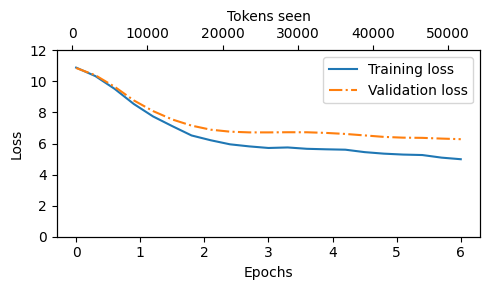

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_5/epoch006_step0000101_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_5/epoch006_step0000101_results.json


{'final_train_loss': 4.988285255432129,
 'final_val_loss': 6.277515649795532,
 'tokens_seen': 51712,
 'global_step': 101}

In [15]:
run_training(cfg2)

## Experiment 6: mini-model, 2 layers, 8 heads per layer, epochs = 6

In [16]:
cfg2['run_name']="gpt2_basic_exp_6"
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=2
cfg2['model_config']['n_heads']=8
cfg2

{'run_name': 'gpt2_basic_exp_6',
 'description': 'gpt2-small on the verdict',
 'device_name': 'cpu',
 'model_name': 'gpt2-small',
 'model_config': {'vocab_size': 50257,
  'context_length': 256,
  'emb_dim': 256,
  'n_heads': 8,
  'n_layers': 2,
  'drop_rate': 0.1,
  'qkv_bias': False,
  'weight_tying': False},
 'tokenizer': 'gpt2',
 'pretrained': False,
 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt',
 'val_file': '',
 'test_file': '',
 'val_ratio': 0.1,
 'test_ratio': 0.0,
 'stride': 128,
 'batch_size': 2,
 'lr': 0.0004,
 'weight_decay': 0.1,
 'num_epochs': 6,
 'seed': 123,
 'output_dir': '/home/markb/llm-from-scratch/output'}

{'run_name': 'gpt2_basic_exp_6', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 256, 'n_heads': 8, 'n_layers': 2, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 27375616
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 256])
tok_emb.weight shape: torch.Size([50257, 256])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (conver

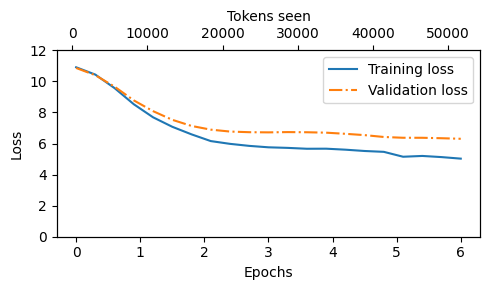

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_6/epoch006_step0000101_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_6/epoch006_step0000101_results.json


{'final_train_loss': 5.025701999664307,
 'final_val_loss': 6.303480625152588,
 'tokens_seen': 51712,
 'global_step': 101}

In [17]:
run_training(cfg2)

## Experiment 7: mini-model, 8 layers, 2 heads per layer, 6 epochs

In [18]:
cfg2['run_name']="gpt2_basic_exp_6"
#cfg2['model_config']['weight_tying']=True
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=8
cfg2['model_config']['n_heads']=2
#cfg2['model_config']['emb_dim']=384
cfg2

{'run_name': 'gpt2_basic_exp_6',
 'description': 'gpt2-small on the verdict',
 'device_name': 'cpu',
 'model_name': 'gpt2-small',
 'model_config': {'vocab_size': 50257,
  'context_length': 256,
  'emb_dim': 256,
  'n_heads': 2,
  'n_layers': 8,
  'drop_rate': 0.1,
  'qkv_bias': False,
  'weight_tying': False},
 'tokenizer': 'gpt2',
 'pretrained': False,
 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt',
 'val_file': '',
 'test_file': '',
 'val_ratio': 0.1,
 'test_ratio': 0.0,
 'stride': 128,
 'batch_size': 2,
 'lr': 0.0004,
 'weight_decay': 0.1,
 'num_epochs': 6,
 'seed': 123,
 'output_dir': '/home/markb/llm-from-scratch/output'}

{'run_name': 'gpt2_basic_exp_6', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 256, 'n_heads': 2, 'n_layers': 8, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 32109568
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 256])
tok_emb.weight shape: torch.Size([50257, 256])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (conver

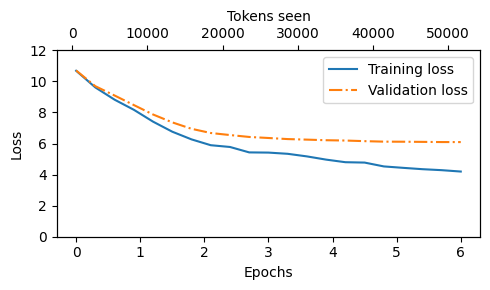

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_6/epoch006_step0000101_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_6/epoch006_step0000101_results.json


{'final_train_loss': 4.19519534111023,
 'final_val_loss': 6.091586351394653,
 'tokens_seen': 51712,
 'global_step': 101}

In [19]:
run_training(cfg2)

## Experiment 8: mini-model, 8 layers, 2 heads per layer, emb_dim=64 6 epochs

{'run_name': 'gpt2_basic_exp_6', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 64, 'n_heads': 2, 'n_layers': 8, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 6847744
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 64])
tok_emb.weight shape: torch.Size([50257, 64])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (converted 

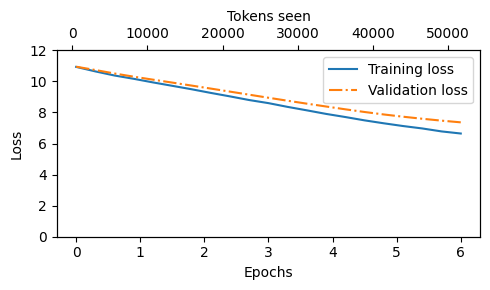

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_6/epoch006_step0000101_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_6/epoch006_step0000101_results.json


{'final_train_loss': 6.642565536499023,
 'final_val_loss': 7.361642837524414,
 'tokens_seen': 51712,
 'global_step': 101}

In [20]:
## Experiment 7: mini-model, 8 layers, 2 heads per layer, 6 epochs
cfg2['run_name']="gpt2_basic_exp_6"
#cfg2['model_config']['weight_tying']=True
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=8
cfg2['model_config']['n_heads']=2
cfg2['model_config']['emb_dim']=64
cfg2
run_training(cfg2)

## Experiment 9: mini-model, 8 layers, 2 heads per layer, emb_dim=64 12 epochs

{'run_name': 'gpt2_basic_exp_9', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 64, 'n_heads': 2, 'n_layers': 8, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 12, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 6847744
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 64])
tok_emb.weight shape: torch.Size([50257, 64])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (converted

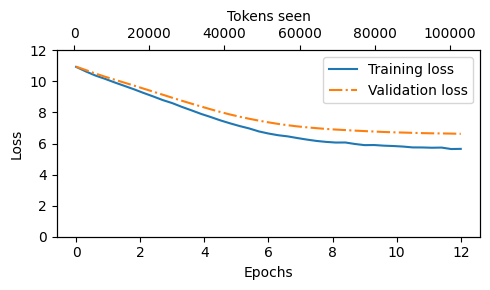

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_9/epoch012_step0000203_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_9/epoch012_step0000203_results.json


{'final_train_loss': 5.654611396789551,
 'final_val_loss': 6.623379230499268,
 'tokens_seen': 102912,
 'global_step': 203}

In [21]:

cfg2['run_name']="gpt2_basic_exp_9"
#cfg2['model_config']['weight_tying']=True
cfg2['num_epochs']=12
cfg2['model_config']['n_layers']=8
cfg2['model_config']['n_heads']=2
cfg2['model_config']['emb_dim']=64
cfg2
run_training(cfg2)

## Experiment 10: mini-model, 8 layers, 8 heads per layer, emb_dim=768 6 epochs

{'run_name': 'gpt2_basic_exp_10', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 8, 'n_layers': 8, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 6, 'seed': 123, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 134077440
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 768])
tok_emb.weight shape: torch.Size([50257, 768])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/The-watch-story-adj-smaller-2.txt
Characters: 21153
Tokens: 5186


Show train_loader first entry (conv

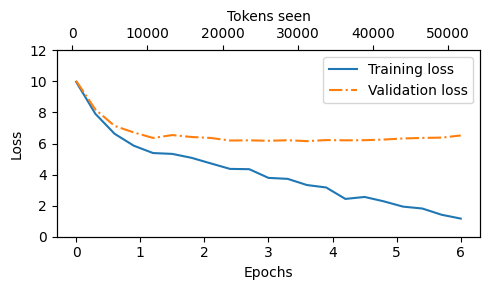

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_basic_exp_10/epoch006_step0000101_cfg.json
Saved results to /home/markb/llm-from-scratch/output/gpt2_basic_exp_10/epoch006_step0000101_results.json


{'final_train_loss': 1.1672343730926513,
 'final_val_loss': 6.517212390899658,
 'tokens_seen': 51712,
 'global_step': 101}

In [22]:

cfg2['run_name']="gpt2_basic_exp_10"
#cfg2['model_config']['weight_tying']=True
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=8
cfg2['model_config']['n_heads']=8
cfg2['model_config']['emb_dim']=768
cfg2
run_training(cfg2)